In [ ]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

Name = "Victor Martinez Palomares"
Matriculation_Number = "7021729"

Name = "Soham Roy"
Matriculation_Number = "7028704"

In [36]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ./datasets
!cp -r drive/MyDrive/Colab\ Notebooks/HLCV_project/datasets/lyme_dataset.zip ./datasets
!unzip ./datasets/lyme_dataset.zip

'''
!mkdir ./resources


!cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources
!cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources

'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘./datasets’: File exists
cp: cannot stat 'drive/MyDrive/Colab Notebooks/HLCV_project/datasets/lyme_dataset.zip': No such file or directory
unzip:  cannot find or open ./datasets/lyme_dataset.zip, ./datasets/lyme_dataset.zip.zip or ./datasets/lyme_dataset.zip.ZIP.


'\n!mkdir ./resources\n\n\n!cp -r drive/MyDrive/Colab\\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources\n!cp -r drive/MyDrive/Colab\\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources\n\n'

In [21]:
import os
import glob
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt




### Params

In [7]:
IMAGE_SIZE = 256
EPOCHS = 120
BATCH = 8
LR = 1e-4

path = "./datasets/lyme_dataset/RashData"

### Loading fine-tuning dataset

In [28]:
def load_data(path, train=True):
  if train:
    # load train data
    images = sorted(Path(os.path.join(path, "Train/Train_2_Cases/Lyme_Negative")).glob('**/*'))
    #images = sorted(glob(os.path.join(path, "Train/Train_2_Cases/Lyme_Negative/*")))
    masks = np.zeros(len(images))
    images1 = sorted(Path(os.path.join(path, "Train/Train_2_Cases/Lyme_Positive")).glob('**/*'))
    #images1 = (sorted(glob(os.path.join(path, "Train/Train_2_Cases/Lyme_Positive/*"))))
    images = images + images1
    masks = np.concatenate([masks,np.ones(len(images1))])
    total_size = len(images)
    dataset = list(zip(images, masks))
    random.shuffle(dataset)
    '''
    # split train/val data
    val_size = int(split * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    '''
    # unzip train data
    images, masks = zip(*dataset)
    #train_x = list(images)
    train_x = list(map(str, images))
    train_y = np.array(list(masks))

    return train_x, train_y
  else:
    # load test data
    images = sorted(Path(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Negative")).glob('**/*'))
    #images = sorted(glob(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Negative/*")))
    masks = np.zeros(len(images))
    images1 = sorted(Path(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Positive")).glob('**/*'))
    #images1 = (sorted(glob(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Positive/*"))))
    images = images + images1
    masks = np.concatenate([masks,np.ones(len(images1))])

    c = list(zip(images, masks))
    random.shuffle(c)
    images, masks = zip(*c)

    #test_x = list(images)
    test_x = list(map(str, images))
    test_y = np.array(list(masks))

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return test_x, test_y

In [29]:
train_x, train_y = load_data(path, train=True)
print("Training data: ", (train_x))
print(len(train_x))
test_x, test_y = load_data(path, train=False)
print("Testing data: ", (test_x))
print(len(test_x))

Training data:  ['datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm106.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm100.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans148.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash103.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm69.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash34.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm22.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans242.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash30.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans62.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans109

In [30]:
class LymeDataset(Dataset):
  def __init__(self, img_dir, train=True, transform=None):
    '''
    Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied
      on a sample.
    '''
    self.train = train
    self.img_dir = img_dir
    self.transform = transform
    self.images_path, self.labels = load_data(img_dir, train)
  

  def __len__(self) -> int:
    return len(self.labels)

  def __getitem__(self, idx):
    img_path = self.images_path[idx]
    image = read_image(img_path)
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

In [33]:
# Now
#import torch
#torch.manual_seed(17)
data_aug_transforms = []
data_aug_transforms.append(transforms.RandomRotation([-90, 90]) ) # geometric
data_aug_transforms.append( transforms.RandomHorizontalFlip() )  # geometric
data_aug_transforms.append(transforms.ColorJitter(brightness = 0.2)) # brightness
transformations = transforms.Compose(data_aug_transforms)
#[transforms.ToTensor(), +[transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
lyme_dataset = LymeDataset(img_dir=path, train=True, transform=transformations)
print(lyme_dataset)

TypeError: ignored

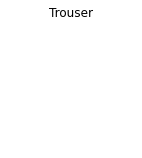

In [34]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(lyme_dataset), size=(1,)).item()
    img, label = lyme_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
'''
def tf_parse(x,y):
  def _parse(x,y):
      x = read_image(x)
      return x,y

  x,y = tf.numpy_function(_parse, [x,y],  [tf.float64, tf.float64])
  #y = tf.cast(y, tf.double)
  x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
  #x = tf.cast(x, tf.double)
  return x,y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse)
  #print(dataset)
  dataset = dataset.map(data_augmentation)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)
'''

### Extra code

In [ ]:
images= np.zeros(20)
labels = np.ones(20)
data = list(zip(images,labels))
print(len(data))
print(data)
print(data.shape)

20
[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]


AttributeError: ignored